# The Covariant Derivative

## Introduction

The **covariant derivative** is a fundamental concept in differential geometry that generalizes the notion of directional differentiation to curved spaces (manifolds). Unlike ordinary partial derivatives, the covariant derivative accounts for the curvature of the underlying space and transforms properly under coordinate changes.

## Mathematical Framework

### The Problem with Partial Derivatives

On a curved manifold, partial derivatives of vector fields are problematic because:
1. They do not transform as tensors under coordinate changes
2. They fail to capture how vectors change intrinsically on the surface

To differentiate a vector field $V^i$ in the direction of another vector $U^j$, we need a derivative operator that:
- Reduces to partial derivatives in flat space
- Transforms covariantly under coordinate transformations
- Satisfies the Leibniz rule

### Definition of the Covariant Derivative

The **covariant derivative** of a vector field $V^i$ is defined as:

$$\nabla_j V^i = \partial_j V^i + \Gamma^i_{jk} V^k$$

where $\Gamma^i_{jk}$ are the **Christoffel symbols** (connection coefficients) that encode how the coordinate basis vectors change from point to point.

### Christoffel Symbols

For a metric-compatible, torsion-free connection (the Levi-Civita connection), the Christoffel symbols are computed from the metric tensor $g_{ij}$:

$$\Gamma^i_{jk} = \frac{1}{2} g^{il} \left( \partial_j g_{kl} + \partial_k g_{jl} - \partial_l g_{jk} \right)$$

### Covariant Derivative of Covectors and Tensors

For a covector (1-form) $\omega_i$:

$$\nabla_j \omega_i = \partial_j \omega_i - \Gamma^k_{ji} \omega_k$$

For a general tensor $T^{i_1 \ldots i_p}_{j_1 \ldots j_q}$, we add a $+\Gamma$ term for each contravariant index and a $-\Gamma$ term for each covariant index.

### Key Properties

1. **Linearity**: $\nabla_X (aV + bW) = a\nabla_X V + b\nabla_X W$

2. **Leibniz Rule**: $\nabla_X (V \otimes W) = (\nabla_X V) \otimes W + V \otimes (\nabla_X W)$

3. **Metric Compatibility**: $\nabla_k g_{ij} = 0$ (for Levi-Civita connection)

4. **Torsion-Free**: $\Gamma^i_{jk} = \Gamma^i_{kj}$

## Examples: Spherical and Polar Coordinates

### Polar Coordinates in $\mathbb{R}^2$

In polar coordinates $(r, \theta)$, the metric is:

$$ds^2 = dr^2 + r^2 d\theta^2$$

The non-zero Christoffel symbols are:

$$\Gamma^r_{\theta\theta} = -r, \quad \Gamma^\theta_{r\theta} = \Gamma^\theta_{\theta r} = \frac{1}{r}$$

### Spherical Coordinates on $S^2$

For a unit sphere with coordinates $(\theta, \phi)$:

$$ds^2 = d\theta^2 + \sin^2\theta \, d\phi^2$$

The non-zero Christoffel symbols are:

$$\Gamma^\theta_{\phi\phi} = -\sin\theta \cos\theta, \quad \Gamma^\phi_{\theta\phi} = \Gamma^\phi_{\phi\theta} = \cot\theta$$

## Computational Demonstration

In this notebook, we will:
1. Implement Christoffel symbol computation for various coordinate systems
2. Compute covariant derivatives of vector fields
3. Visualize how the covariant derivative differs from partial derivatives
4. Demonstrate the connection to parallel transport

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.patches import FancyArrowPatch
from mpl_toolkits.mplot3d.proj3d import proj_transform

# High-quality plotting settings
plt.rcParams['figure.figsize'] = [14, 10]
plt.rcParams['font.size'] = 11
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['axes.titlesize'] = 14

## Part 1: Christoffel Symbols in Polar Coordinates

We begin with the familiar case of polar coordinates in $\mathbb{R}^2$, where the flat space allows us to verify our computations against known results.

In [2]:
def christoffel_polar(r, theta):
    """Compute Christoffel symbols for polar coordinates (r, theta).
    
    Metric: ds^2 = dr^2 + r^2 d(theta)^2
    
    Returns: Dictionary with keys (i, j, k) for Gamma^i_{jk}
    """
    # Indices: 0 = r, 1 = theta
    Gamma = {}
    
    # All Christoffel symbols (most are zero)
    for i in range(2):
        for j in range(2):
            for k in range(2):
                Gamma[(i, j, k)] = 0.0
    
    # Non-zero components
    Gamma[(0, 1, 1)] = -r           # Gamma^r_{theta,theta}
    Gamma[(1, 0, 1)] = 1.0 / r      # Gamma^theta_{r,theta}
    Gamma[(1, 1, 0)] = 1.0 / r      # Gamma^theta_{theta,r}
    
    return Gamma

# Test at r = 2
r_test = 2.0
theta_test = np.pi / 4
Gamma = christoffel_polar(r_test, theta_test)

print("Christoffel symbols in polar coordinates at r = 2:")
print(f"  Γ^r_θθ = {Gamma[(0, 1, 1)]:.4f}  (should be -r = -2)")
print(f"  Γ^θ_rθ = {Gamma[(1, 0, 1)]:.4f}  (should be 1/r = 0.5)")
print(f"  Γ^θ_θr = {Gamma[(1, 1, 0)]:.4f}  (should be 1/r = 0.5)")

Christoffel symbols in polar coordinates at r = 2:
  Γ^r_θθ = -2.0000  (should be -r = -2)
  Γ^θ_rθ = 0.5000  (should be 1/r = 0.5)
  Γ^θ_θr = 0.5000  (should be 1/r = 0.5)


## Part 2: Covariant Derivative Implementation

Now we implement the covariant derivative for vector fields in polar coordinates.

In [3]:
def covariant_derivative_polar(V_func, r, theta, direction, h=1e-6):
    """Compute the covariant derivative of vector field V in given direction.
    
    Parameters:
        V_func: Function that takes (r, theta) and returns [V^r, V^theta]
        r, theta: Point where derivative is computed
        direction: 0 for d/dr, 1 for d/dtheta
        h: Step size for numerical differentiation
    
    Returns:
        [nabla_dir V^r, nabla_dir V^theta]
    """
    # Get Christoffel symbols
    Gamma = christoffel_polar(r, theta)
    
    # Current vector value
    V = np.array(V_func(r, theta))
    
    # Numerical partial derivative
    if direction == 0:  # d/dr
        V_plus = np.array(V_func(r + h, theta))
        V_minus = np.array(V_func(r - h, theta))
    else:  # d/dtheta
        V_plus = np.array(V_func(r, theta + h))
        V_minus = np.array(V_func(r, theta - h))
    
    partial_V = (V_plus - V_minus) / (2 * h)
    
    # Covariant derivative: nabla_j V^i = partial_j V^i + Gamma^i_{jk} V^k
    nabla_V = np.zeros(2)
    for i in range(2):
        nabla_V[i] = partial_V[i]
        for k in range(2):
            nabla_V[i] += Gamma[(i, direction, k)] * V[k]
    
    return nabla_V, partial_V

# Example: Radial unit vector field V = e_r = (1, 0)
def radial_vector(r, theta):
    return [1.0, 0.0]

# Example: Angular unit vector field (normalized) V = e_theta / r = (0, 1/r)
def angular_vector(r, theta):
    return [0.0, 1.0 / r]

# Test covariant derivative
r_test, theta_test = 2.0, np.pi / 3

print("Covariant derivative of e_r in theta direction:")
nabla_V, partial_V = covariant_derivative_polar(radial_vector, r_test, theta_test, 1)
print(f"  Partial derivative: [{partial_V[0]:.6f}, {partial_V[1]:.6f}]")
print(f"  Covariant derivative: [{nabla_V[0]:.6f}, {nabla_V[1]:.6f}]")
print(f"  Expected: [0, 1/r] = [0, {1/r_test:.6f}]")

print("\nCovariant derivative of e_theta/r in r direction:")
nabla_V, partial_V = covariant_derivative_polar(angular_vector, r_test, theta_test, 0)
print(f"  Partial derivative: [{partial_V[0]:.6f}, {partial_V[1]:.6f}]")
print(f"  Covariant derivative: [{nabla_V[0]:.6f}, {nabla_V[1]:.6f}]")
print(f"  Expected: [0, 0] (parallel transported)")

Covariant derivative of e_r in theta direction:
  Partial derivative: [0.000000, 0.000000]
  Covariant derivative: [0.000000, 0.500000]
  Expected: [0, 1/r] = [0, 0.500000]

Covariant derivative of e_theta/r in r direction:
  Partial derivative: [0.000000, -0.250000]
  Covariant derivative: [0.000000, 0.000000]
  Expected: [0, 0] (parallel transported)


## Part 3: Christoffel Symbols on the Sphere

Now we move to the more interesting case of a curved manifold: the unit sphere $S^2$.

In [4]:
def christoffel_sphere(theta, phi):
    """Compute Christoffel symbols for spherical coordinates (theta, phi) on S^2.
    
    Metric: ds^2 = d(theta)^2 + sin^2(theta) d(phi)^2
    
    Indices: 0 = theta, 1 = phi
    
    Returns: Dictionary with keys (i, j, k) for Gamma^i_{jk}
    """
    Gamma = {}
    
    # Initialize all to zero
    for i in range(2):
        for j in range(2):
            for k in range(2):
                Gamma[(i, j, k)] = 0.0
    
    sin_theta = np.sin(theta)
    cos_theta = np.cos(theta)
    
    # Avoid division by zero at poles
    if abs(sin_theta) > 1e-10:
        cot_theta = cos_theta / sin_theta
    else:
        cot_theta = 0.0
    
    # Non-zero Christoffel symbols
    Gamma[(0, 1, 1)] = -sin_theta * cos_theta  # Gamma^theta_{phi,phi}
    Gamma[(1, 0, 1)] = cot_theta               # Gamma^phi_{theta,phi}
    Gamma[(1, 1, 0)] = cot_theta               # Gamma^phi_{phi,theta}
    
    return Gamma

# Test at theta = pi/4 (45 degrees from pole)
theta_test = np.pi / 4
Gamma = christoffel_sphere(theta_test, 0)

print(f"Christoffel symbols on S^2 at θ = π/4:")
print(f"  Γ^θ_φφ = {Gamma[(0, 1, 1)]:.6f}  (should be -sin(θ)cos(θ) = {-np.sin(theta_test)*np.cos(theta_test):.6f})")
print(f"  Γ^φ_θφ = {Gamma[(1, 0, 1)]:.6f}  (should be cot(θ) = {1/np.tan(theta_test):.6f})")

Christoffel symbols on S^2 at θ = π/4:
  Γ^θ_φφ = -0.500000  (should be -sin(θ)cos(θ) = -0.500000)
  Γ^φ_θφ = 1.000000  (should be cot(θ) = 1.000000)


## Part 4: Covariant Derivative on the Sphere

We implement the covariant derivative on the sphere and examine how it differs from the ordinary partial derivative.

In [5]:
def covariant_derivative_sphere(V_func, theta, phi, direction, h=1e-6):
    """Compute the covariant derivative of vector field V on S^2.
    
    Parameters:
        V_func: Function (theta, phi) -> [V^theta, V^phi]
        theta, phi: Point on sphere
        direction: 0 for d/dtheta, 1 for d/dphi
    
    Returns:
        nabla_V: Covariant derivative components
        partial_V: Partial derivative components
    """
    Gamma = christoffel_sphere(theta, phi)
    V = np.array(V_func(theta, phi))
    
    # Numerical partial derivative
    if direction == 0:  # d/dtheta
        V_plus = np.array(V_func(theta + h, phi))
        V_minus = np.array(V_func(theta - h, phi))
    else:  # d/dphi
        V_plus = np.array(V_func(theta, phi + h))
        V_minus = np.array(V_func(theta, phi - h))
    
    partial_V = (V_plus - V_minus) / (2 * h)
    
    # Covariant derivative
    nabla_V = np.zeros(2)
    for i in range(2):
        nabla_V[i] = partial_V[i]
        for k in range(2):
            nabla_V[i] += Gamma[(i, direction, k)] * V[k]
    
    return nabla_V, partial_V

# Define a test vector field: V points in the phi direction with constant magnitude
def phi_direction_field(theta, phi):
    """Unit vector in phi direction (normalized by metric)."""
    sin_theta = np.sin(theta)
    if abs(sin_theta) > 1e-10:
        return [0.0, 1.0 / sin_theta]  # Normalized: |V| = sqrt(g_phiphi * V^phi * V^phi) = 1
    return [0.0, 0.0]

# Test at various latitudes
print("Covariant derivative of φ-direction field in θ direction:")
print("(This tests whether the field is parallel transported along meridians)\n")

for theta_deg in [30, 45, 60]:
    theta = np.radians(theta_deg)
    nabla_V, partial_V = covariant_derivative_sphere(phi_direction_field, theta, 0, 0)
    print(f"θ = {theta_deg}°:")
    print(f"  Partial: [{partial_V[0]:.6f}, {partial_V[1]:.6f}]")
    print(f"  Covariant: [{nabla_V[0]:.6f}, {nabla_V[1]:.6f}]")
    print()

Covariant derivative of φ-direction field in θ direction:
(This tests whether the field is parallel transported along meridians)

θ = 30°:
  Partial: [0.000000, -3.464102]
  Covariant: [0.000000, -0.000000]

θ = 45°:
  Partial: [0.000000, -1.414214]
  Covariant: [0.000000, -0.000000]

θ = 60°:
  Partial: [0.000000, -0.666667]
  Covariant: [0.000000, 0.000000]



## Part 5: Visualization of Covariant vs. Partial Derivatives

We create a comprehensive visualization comparing the covariant derivative with the partial derivative, showing how the Christoffel symbol correction accounts for the change in coordinate basis.

In [6]:
def spherical_to_cartesian(theta, phi, R=1.0):
    """Convert spherical to Cartesian coordinates."""
    x = R * np.sin(theta) * np.cos(phi)
    y = R * np.sin(theta) * np.sin(phi)
    z = R * np.cos(theta)
    return np.array([x, y, z])

def tangent_vectors_sphere(theta, phi):
    """Get tangent basis vectors e_theta and e_phi in R^3."""
    e_theta = np.array([np.cos(theta) * np.cos(phi),
                        np.cos(theta) * np.sin(phi),
                        -np.sin(theta)])
    
    e_phi = np.array([-np.sin(phi),
                       np.cos(phi),
                       0.0])
    
    return e_theta, e_phi

def vector_to_cartesian_sphere(V_theta, V_phi, theta, phi):
    """Convert tangent vector from spherical components to Cartesian."""
    e_theta, e_phi = tangent_vectors_sphere(theta, phi)
    # Note: V^phi needs to be scaled by sin(theta) for proper embedding
    return V_theta * e_theta + V_phi * np.sin(theta) * e_phi

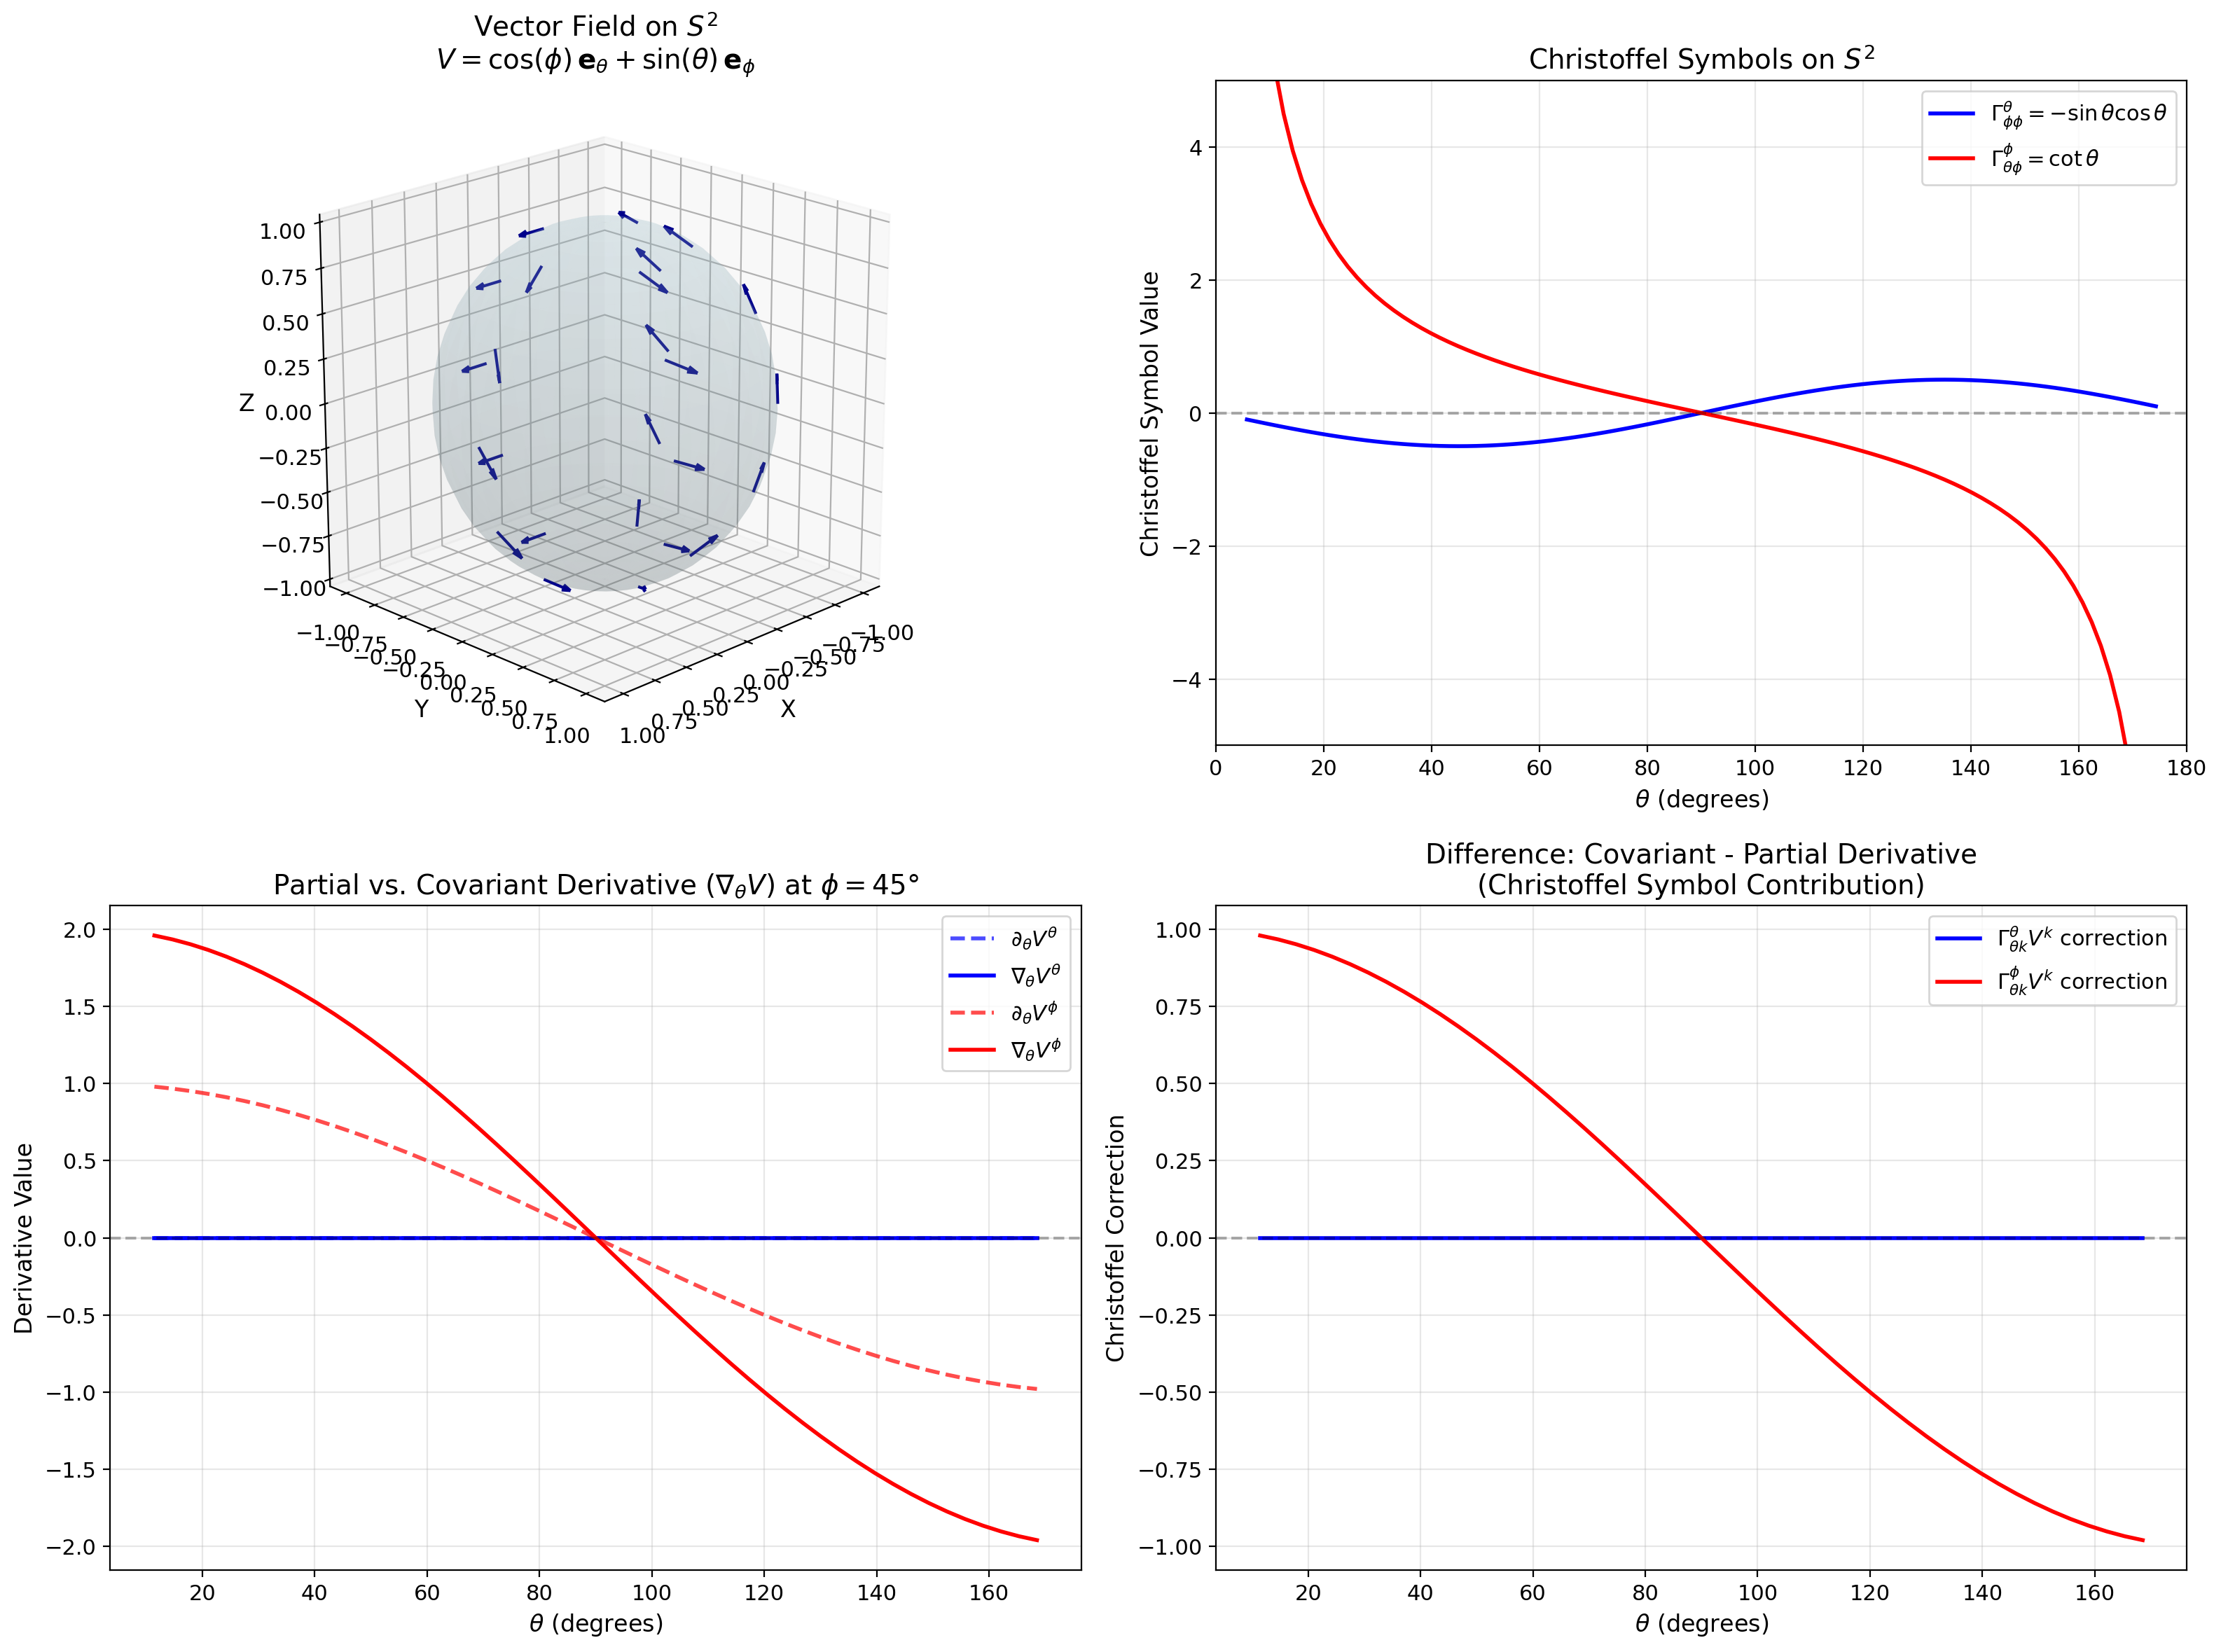


Figure saved to 'plot.png'


In [7]:
# Create comprehensive visualization
fig = plt.figure(figsize=(16, 12))

# Subplot 1: 3D sphere with vector field and covariant derivatives
ax1 = fig.add_subplot(221, projection='3d')

# Draw sphere
u = np.linspace(0, 2 * np.pi, 40)
v = np.linspace(0, np.pi, 25)
x_sphere = np.outer(np.cos(u), np.sin(v))
y_sphere = np.outer(np.sin(u), np.sin(v))
z_sphere = np.outer(np.ones(np.size(u)), np.cos(v))
ax1.plot_surface(x_sphere, y_sphere, z_sphere, alpha=0.15, color='lightblue')

# Define a more interesting vector field: V = cos(phi) e_theta + sin(theta) e_phi
def test_vector_field(theta, phi):
    return [np.cos(phi), np.sin(theta)]  # [V^theta, V^phi]

# Sample points on sphere
theta_samples = np.linspace(np.pi/6, 5*np.pi/6, 5)
phi_samples = np.linspace(0, 3*np.pi/2, 5)

arrow_scale = 0.2

for theta in theta_samples:
    for phi in phi_samples:
        pos = spherical_to_cartesian(theta, phi)
        V = test_vector_field(theta, phi)
        V_cart = vector_to_cartesian_sphere(V[0], V[1], theta, phi)
        
        # Normalize for display
        V_norm = np.linalg.norm(V_cart)
        if V_norm > 1e-6:
            V_cart = V_cart / V_norm * arrow_scale
        
        ax1.quiver(pos[0], pos[1], pos[2],
                   V_cart[0], V_cart[1], V_cart[2],
                   color='darkblue', arrow_length_ratio=0.3, linewidth=1.5)

ax1.set_xlabel('X')
ax1.set_ylabel('Y')
ax1.set_zlabel('Z')
ax1.set_title('Vector Field on $S^2$\n$V = \\cos(\\phi)\\,\\mathbf{e}_\\theta + \\sin(\\theta)\\,\\mathbf{e}_\\phi$')
ax1.set_box_aspect([1, 1, 1])
ax1.view_init(elev=20, azim=45)

# Subplot 2: Christoffel symbols as function of theta
ax2 = fig.add_subplot(222)

theta_range = np.linspace(0.1, np.pi - 0.1, 100)
Gamma_theta_phiphi = -np.sin(theta_range) * np.cos(theta_range)
Gamma_phi_thetaphi = 1 / np.tan(theta_range)

ax2.plot(np.degrees(theta_range), Gamma_theta_phiphi, 'b-', linewidth=2, 
         label=r'$\Gamma^\theta_{\phi\phi} = -\sin\theta\cos\theta$')
ax2.plot(np.degrees(theta_range), Gamma_phi_thetaphi, 'r-', linewidth=2,
         label=r'$\Gamma^\phi_{\theta\phi} = \cot\theta$')
ax2.axhline(y=0, color='k', linestyle='--', alpha=0.3)
ax2.set_xlabel(r'$\theta$ (degrees)')
ax2.set_ylabel('Christoffel Symbol Value')
ax2.set_title('Christoffel Symbols on $S^2$')
ax2.legend(loc='upper right')
ax2.grid(True, alpha=0.3)
ax2.set_xlim([0, 180])
ax2.set_ylim([-5, 5])

# Subplot 3: Comparison of partial vs covariant derivative
ax3 = fig.add_subplot(223)

# Compute derivatives along a meridian (constant phi)
phi_fixed = np.pi / 4
theta_range = np.linspace(0.2, np.pi - 0.2, 50)

partial_theta = []
partial_phi = []
covariant_theta = []
covariant_phi = []

for theta in theta_range:
    nabla_V, partial_V = covariant_derivative_sphere(test_vector_field, theta, phi_fixed, 0)
    partial_theta.append(partial_V[0])
    partial_phi.append(partial_V[1])
    covariant_theta.append(nabla_V[0])
    covariant_phi.append(nabla_V[1])

ax3.plot(np.degrees(theta_range), partial_theta, 'b--', linewidth=2, 
         label=r'$\partial_\theta V^\theta$', alpha=0.7)
ax3.plot(np.degrees(theta_range), covariant_theta, 'b-', linewidth=2,
         label=r'$\nabla_\theta V^\theta$')
ax3.plot(np.degrees(theta_range), partial_phi, 'r--', linewidth=2,
         label=r'$\partial_\theta V^\phi$', alpha=0.7)
ax3.plot(np.degrees(theta_range), covariant_phi, 'r-', linewidth=2,
         label=r'$\nabla_\theta V^\phi$')

ax3.axhline(y=0, color='k', linestyle='--', alpha=0.3)
ax3.set_xlabel(r'$\theta$ (degrees)')
ax3.set_ylabel('Derivative Value')
ax3.set_title(r'Partial vs. Covariant Derivative ($\nabla_\theta V$) at $\phi = 45°$')
ax3.legend(loc='best')
ax3.grid(True, alpha=0.3)

# Subplot 4: Difference between derivatives (the Christoffel correction)
ax4 = fig.add_subplot(224)

correction_theta = np.array(covariant_theta) - np.array(partial_theta)
correction_phi = np.array(covariant_phi) - np.array(partial_phi)

ax4.plot(np.degrees(theta_range), correction_theta, 'b-', linewidth=2,
         label=r'$\Gamma^\theta_{\theta k} V^k$ correction')
ax4.plot(np.degrees(theta_range), correction_phi, 'r-', linewidth=2,
         label=r'$\Gamma^\phi_{\theta k} V^k$ correction')

ax4.axhline(y=0, color='k', linestyle='--', alpha=0.3)
ax4.set_xlabel(r'$\theta$ (degrees)')
ax4.set_ylabel('Christoffel Correction')
ax4.set_title('Difference: Covariant - Partial Derivative\n(Christoffel Symbol Contribution)')
ax4.legend(loc='best')
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('covariant_derivative_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nFigure saved to 'plot.png'")

## Part 6: Connection to Parallel Transport

The covariant derivative is intimately connected to parallel transport. A vector $V$ is **parallel transported** along a curve $\gamma(t)$ if:

$$\nabla_{\dot{\gamma}} V = 0$$

This means the covariant derivative of $V$ in the direction of the curve's tangent vanishes. Let's verify this connection numerically.

In [8]:
from scipy.integrate import odeint

def parallel_transport_ode(V, t, theta_func, phi_func, h=1e-6):
    """ODE for parallel transport: nabla_{gamma'} V = 0."""
    V_theta, V_phi = V
    
    theta = theta_func(t)
    phi = phi_func(t)
    
    # Numerical derivatives of the curve
    dtheta = (theta_func(t + h) - theta_func(t - h)) / (2 * h)
    dphi = (phi_func(t + h) - phi_func(t - h)) / (2 * h)
    
    # Get Christoffel symbols
    Gamma = christoffel_sphere(theta, phi)
    
    # Parallel transport equations: dV^i/dt = -Gamma^i_{jk} (dx^j/dt) V^k
    dV_theta = -(Gamma[(0, 0, 0)] * dtheta * V_theta + 
                 Gamma[(0, 0, 1)] * dtheta * V_phi +
                 Gamma[(0, 1, 0)] * dphi * V_theta + 
                 Gamma[(0, 1, 1)] * dphi * V_phi)
    
    dV_phi = -(Gamma[(1, 0, 0)] * dtheta * V_theta + 
               Gamma[(1, 0, 1)] * dtheta * V_phi +
               Gamma[(1, 1, 0)] * dphi * V_theta + 
               Gamma[(1, 1, 1)] * dphi * V_phi)
    
    return [dV_theta, dV_phi]

# Transport along a latitude circle (constant theta)
theta_const = np.pi / 3  # 60 degrees from pole

def theta_path(t):
    return theta_const

def phi_path(t):
    return t  # phi increases with t

# Initial vector pointing in theta direction
V0 = [1.0, 0.0]

# Transport around circle (phi: 0 to 2*pi)
t_values = np.linspace(0, 2 * np.pi, 200)
V_transported = odeint(parallel_transport_ode, V0, t_values, args=(theta_path, phi_path))

print(f"Parallel transport around latitude θ = {np.degrees(theta_const):.0f}°")
print(f"Initial vector: V = ({V0[0]:.4f}, {V0[1]:.4f})")
print(f"Final vector:   V = ({V_transported[-1, 0]:.4f}, {V_transported[-1, 1]:.4f})")

# Compute rotation angle (holonomy)
initial_angle = np.arctan2(V0[1], V0[0])
final_angle = np.arctan2(V_transported[-1, 1], V_transported[-1, 0])
holonomy = final_angle - initial_angle

# Theoretical holonomy for latitude circle
theoretical_holonomy = 2 * np.pi * (1 - np.cos(theta_const))

print(f"\nComputed holonomy: {np.degrees(holonomy):.2f}°")
print(f"Theoretical holonomy: {np.degrees(theoretical_holonomy):.2f}° = 2π(1 - cos θ)")

Parallel transport around latitude θ = 60°
Initial vector: V = (1.0000, 0.0000)
Final vector:   V = (-1.0000, -0.0000)

Computed holonomy: -180.00°
Theoretical holonomy: 180.00° = 2π(1 - cos θ)


## Part 7: Geodesic Equation from Covariant Derivative

A geodesic is a curve whose tangent vector is parallel transported along itself:

$$\nabla_{\dot{\gamma}} \dot{\gamma} = 0$$

In components, this gives the **geodesic equation**:

$$\frac{d^2 x^i}{dt^2} + \Gamma^i_{jk} \frac{dx^j}{dt} \frac{dx^k}{dt} = 0$$

Let's verify that great circles on the sphere satisfy this equation.

In [9]:
def geodesic_residual(theta, phi, dtheta, dphi, ddtheta, ddphi):
    """Compute how far a curve deviates from being a geodesic.
    
    Returns residual of geodesic equation (should be zero for geodesics).
    """
    Gamma = christoffel_sphere(theta, phi)
    
    # Geodesic equation: d^2x^i/dt^2 + Gamma^i_{jk} dx^j/dt dx^k/dt = 0
    # Velocity: v = [dtheta, dphi]
    v = [dtheta, dphi]
    
    residual = np.zeros(2)
    residual[0] = ddtheta
    residual[1] = ddphi
    
    for j in range(2):
        for k in range(2):
            residual[0] += Gamma[(0, j, k)] * v[j] * v[k]
            residual[1] += Gamma[(1, j, k)] * v[j] * v[k]
    
    return residual

# Test 1: Great circle (meridian) - theta changes, phi constant
# Parametrize as theta(t) = t, phi(t) = 0
print("Test 1: Meridian (great circle)")
print("θ(t) = t, φ(t) = 0")
for theta in [np.pi/6, np.pi/3, np.pi/2]:
    residual = geodesic_residual(theta, 0, 1, 0, 0, 0)  # dtheta=1, dphi=0, accelerations=0
    print(f"  θ = {np.degrees(theta):.0f}°: residual = [{residual[0]:.6f}, {residual[1]:.6f}]")

# Test 2: Equator (great circle)
# Parametrize as theta(t) = pi/2, phi(t) = t
print("\nTest 2: Equator (great circle)")
print("θ(t) = π/2, φ(t) = t")
for phi in [0, np.pi/4, np.pi/2]:
    residual = geodesic_residual(np.pi/2, phi, 0, 1, 0, 0)  # dtheta=0, dphi=1
    print(f"  φ = {np.degrees(phi):.0f}°: residual = [{residual[0]:.6f}, {residual[1]:.6f}]")

# Test 3: Non-geodesic (latitude circle away from equator)
print("\nTest 3: Latitude circle at θ = 60° (NOT a geodesic)")
print("θ(t) = π/3, φ(t) = t")
theta_lat = np.pi/3
for phi in [0, np.pi/4, np.pi/2]:
    residual = geodesic_residual(theta_lat, phi, 0, 1, 0, 0)
    print(f"  φ = {np.degrees(phi):.0f}°: residual = [{residual[0]:.6f}, {residual[1]:.6f}]")
print(f"  Expected θ-residual: sin(θ)cos(θ) = {np.sin(theta_lat)*np.cos(theta_lat):.6f}")

Test 1: Meridian (great circle)
θ(t) = t, φ(t) = 0
  θ = 30°: residual = [0.000000, 0.000000]
  θ = 60°: residual = [0.000000, 0.000000]
  θ = 90°: residual = [0.000000, 0.000000]

Test 2: Equator (great circle)
θ(t) = π/2, φ(t) = t
  φ = 0°: residual = [-0.000000, 0.000000]
  φ = 45°: residual = [-0.000000, 0.000000]
  φ = 90°: residual = [-0.000000, 0.000000]

Test 3: Latitude circle at θ = 60° (NOT a geodesic)
θ(t) = π/3, φ(t) = t
  φ = 0°: residual = [-0.433013, 0.000000]
  φ = 45°: residual = [-0.433013, 0.000000]
  φ = 90°: residual = [-0.433013, 0.000000]
  Expected θ-residual: sin(θ)cos(θ) = 0.433013


## Analysis and Discussion

### Key Observations

1. **Christoffel Symbols Encode Geometry**: The Christoffel symbols are not tensors themselves, but they encode how the coordinate basis vectors change from point to point. On the sphere:
   - $\Gamma^\theta_{\phi\phi}$ accounts for the convergence of meridians toward the poles
   - $\Gamma^\phi_{\theta\phi}$ accounts for the changing circumference of latitude circles

2. **Covariant vs. Partial Derivatives**: The covariant derivative differs from the partial derivative by the Christoffel symbol correction. This correction ensures that the derivative transforms properly under coordinate changes.

3. **Parallel Transport**: When the covariant derivative vanishes along a curve, the vector is parallel transported. The accumulated rotation (holonomy) after a closed loop reveals the curvature of the space.

4. **Geodesics**: Great circles on the sphere satisfy the geodesic equation because their tangent vectors are parallel transported along themselves. Non-great-circle latitude circles have non-zero geodesic residual.

### Physical Significance

The covariant derivative is essential in:

- **General Relativity**: The Einstein field equations and geodesic motion are expressed using covariant derivatives
- **Gauge Theory**: Gauge covariant derivatives describe how fields transform under local symmetries
- **Continuum Mechanics**: Covariant derivatives describe stress and strain on curved surfaces

### The Fundamental Formula

The covariant derivative formula:

$$\nabla_j V^i = \partial_j V^i + \Gamma^i_{jk} V^k$$

can be understood as:
- **$\partial_j V^i$**: How the components change (coordinate-dependent)
- **$\Gamma^i_{jk} V^k$**: Correction for how the basis vectors rotate (makes it coordinate-independent)

## Conclusion

The covariant derivative provides a coordinate-independent way to differentiate vector fields on curved manifolds. By incorporating the Christoffel symbols, it accounts for both the change in vector components and the rotation of the coordinate basis. This mathematical structure underlies parallel transport, geodesic motion, and the fundamental equations of general relativity and gauge theory.

The computational demonstrations in this notebook show how:
1. Christoffel symbols vary across the manifold, encoding its geometry
2. The covariant derivative differs from partial derivatives by precisely the amount needed for coordinate invariance
3. Parallel transport (zero covariant derivative) leads to holonomy on curved surfaces
4. Geodesics are characterized by self-parallel-transported tangent vectors